In [1]:
from ocean_navigation_simulator.utils.misc import get_c3
import os
%load_ext autoreload
%autoreload 2

In [2]:
c3 = get_c3()

Starting to connect to c3


In [4]:
experiment_name = "multi_agent_dev_2"
exp = c3.Experiment.get(experiment_name)
exp
#exp.remove()

# Set up the experiments

In [5]:
timeout_sim_h = 24*5

In [6]:
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "u_max_in_mps": 0.1,
        "motor_efficiency": 1.0,
        "solar_panel_size": 0.5,
        "solar_efficiency": 0.2,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "HYCOM",
                "type": "hindcast",
                "currents": "total",
                #  "region": "Region 1"
            },
        },
        "forecast": None,#{
        #     "field": "OceanCurrents",
        #     "source": "forecast_files",
        #     "source_settings": {
        #         "folder": "data/miss_gen_forecast/",
        #         "local": False,
        #         "source": "Copernicus",
        #         "type": "forecast",
        #         "currents": "total",
        #         # "region": "Region 1",
        #     },
        #},
    },
    "multi_agent_constraints": {
        "unit": "km",
        "communication_thrsld": 9,
        "epsilon_margin": 1,  # when add edges based on hysteresis
        "collision_thrsld": 0.2,
    },
}
objectiveConfig = {'type': "nav"}

In [7]:
# create Experiment
exp = c3.Experiment.createNew(
    name = experiment_name,
    description = "multi agent dev2",
    arenaConfig = arena_config,
    objectiveConfig= objectiveConfig,
    timeout_in_sec=3600*timeout_sim_h, 
)

# Set up generate batch job

## Set up and run mission generation

In [8]:
import datetime
missGenBatchConfig = {
    ##### Target Sampling #####
    # HYCOM HC: lon [-98.0,-76.4000244140625], lat[18.1200008392334,31.92000007629394]
    # Copernicus FC: lon: [-98.0, -76.416664], lat: [18.083334, 30.0]
    # Combined: [-98.0, -76.416664], [18.1200008392334, 30.0]
    "x_range": [-95.9, -78.52],
    "y_range": [20.22, 30],
    # "x_range": [-160, -105],
    # "y_range": [15, 40],
    "t_range": [  # ['2022-08-01T00:00:00+00:00', '2022-08-30T00:00:00+00:00'],
        # Copernicus FC: 2022-04 until today, HYCOM Hindcast: 2021-09 until today
        datetime.datetime(year=2022, month=8, day=1, tzinfo=datetime.timezone.utc),
        datetime.datetime(year=2022, month=8, day=30, tzinfo=datetime.timezone.utc),
    ],
    "problem_timeout_in_h": 24*6, #to be considered as feasible
    "target_distance_from_land": 0.5,
    "problem_target_radius": 0.1,
    ##### HJ Planner #####
    "hj_specific_settings": {
        # 'grid_res' has to be smaller than target_radius to prevent hj_solver errors
        "grid_res": 0.04,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "direction": "multi-time-reach-back",
        "n_time_vector": 199,  # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "run_without_x_T": True,
        "progress_bar": False,
        "T_goal_in_seconds": 3600 * 24 * 7, #7 days here #
    },
    "hj_planner_box": 2.0,
    ##### Start Sampling #####
    "feasible_missions_per_target": 2,
    "random_missions_per_target": 0,
    "multi_agent": {
        "is_multi_agent": True,
        "nb_platforms": 4,
        "sampling_range_radius_km": 20,
        "sample_range_ttr_h": [70, 110], # this has to be a larger than the "feasible_mission_time_in_h"
        # as the multi-agent points are sampled from "feasible_mission_time_in_h" with added noise which might 
        # increase their ttr by quite a lot (so either this interval has to be increased or the other reduced)
    },
    "min_distance_from_hj_frame": 0.5,
    "min_distance_from_land": 0.5,
    "feasible_mission_time_in_h": [80, 90],
    "random_min_distance_from_target": 0.5,
    ##### Actions #####
    "plot_batch": False,
    "animate_batch": False,
    "cache_forecast": False,
    "cache_hindcast": False,
}

In [10]:
options = c3.GenMissionBatchJobOptionsNicolas(**{
    'experiment':exp,
    'missGenBatchConfig': missGenBatchConfig,
    'base_seed': 99,
    'nBatches': 2,
    'nMissionGenPerBatch': 2, #nb workers on which we loop,
    'hardwareProfileId': "appc8m64-w"
})

global_config {'x_range': [-95.9, -78.52], 'y_range': [20.22, 30], 't_range': [datetime.datetime(2022, 8, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 8, 30, 0, 0, tzinfo=datetime.timezone.utc)], 'problem_timeout_in_h': 144, 'target_distance_from_land': 0.5, 'problem_target_radius': 0.1, 'hj_specific_settings': {'grid_res': 0.04, 'direction': 'multi-time-reach-back', 'n_time_vector': 199, 'accuracy': 'high', 'artificial_dissipation_scheme': 'local_local', 'run_without_x_T': True, 'progress_bar': False, 'T_goal_in_seconds': 604800}, 'hj_planner_box': 2.0, 'feasible_missions_per_target': 2, 'random_missions_per_target': 0, 'multi_agent': {'is_multi_agent': True, 'nb_platforms': 4, 'sampling_range_radius_km': 20, 'sample_range_ttr_h': [70, 110]}, 'min_distance_from_hj_frame': 0.5, 'min_distance_from_land': 0.5, 'feasible_mission_time_in_h': [80, 90], 'random_min_distance_from_target': 0.5, 'plot_batch': False, 'animate_batch': False, 'cache_forecast': False, 'cache_hind

/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning:

No contour levels were found within the data range.



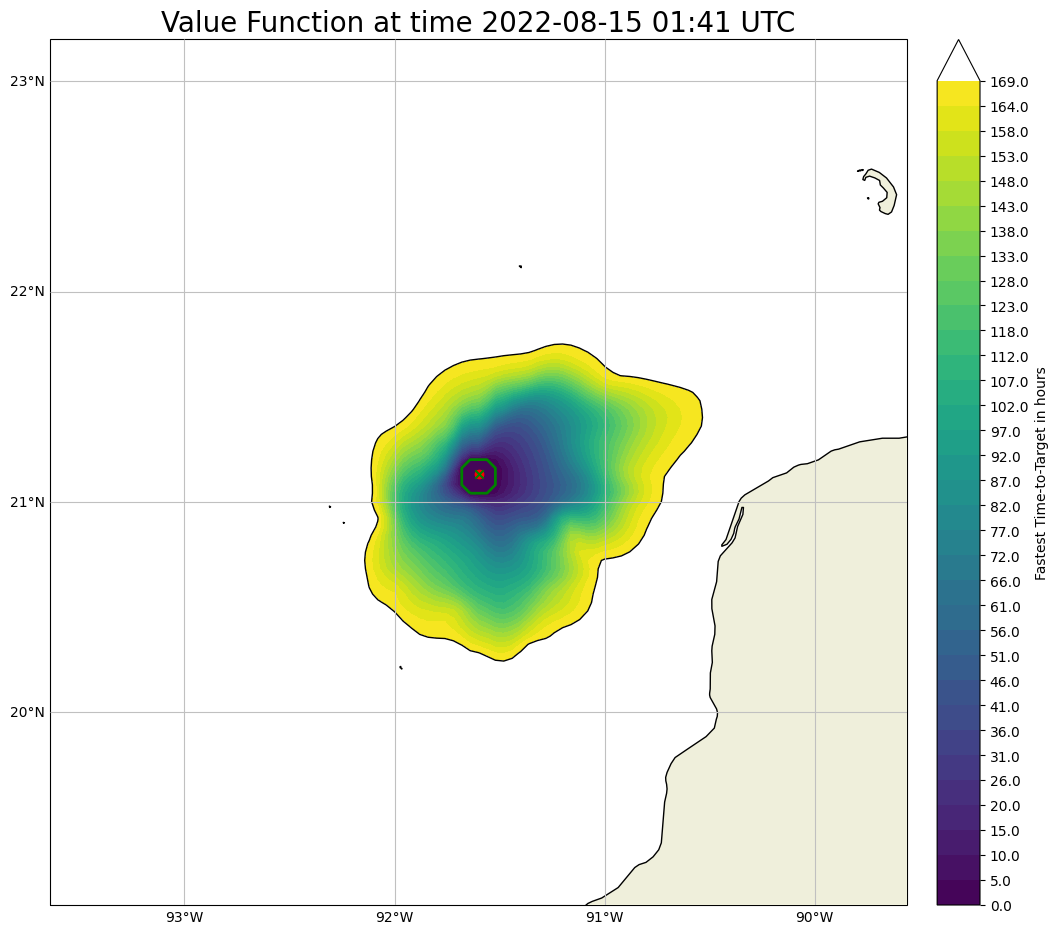

/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning:

No contour levels were found within the data range.



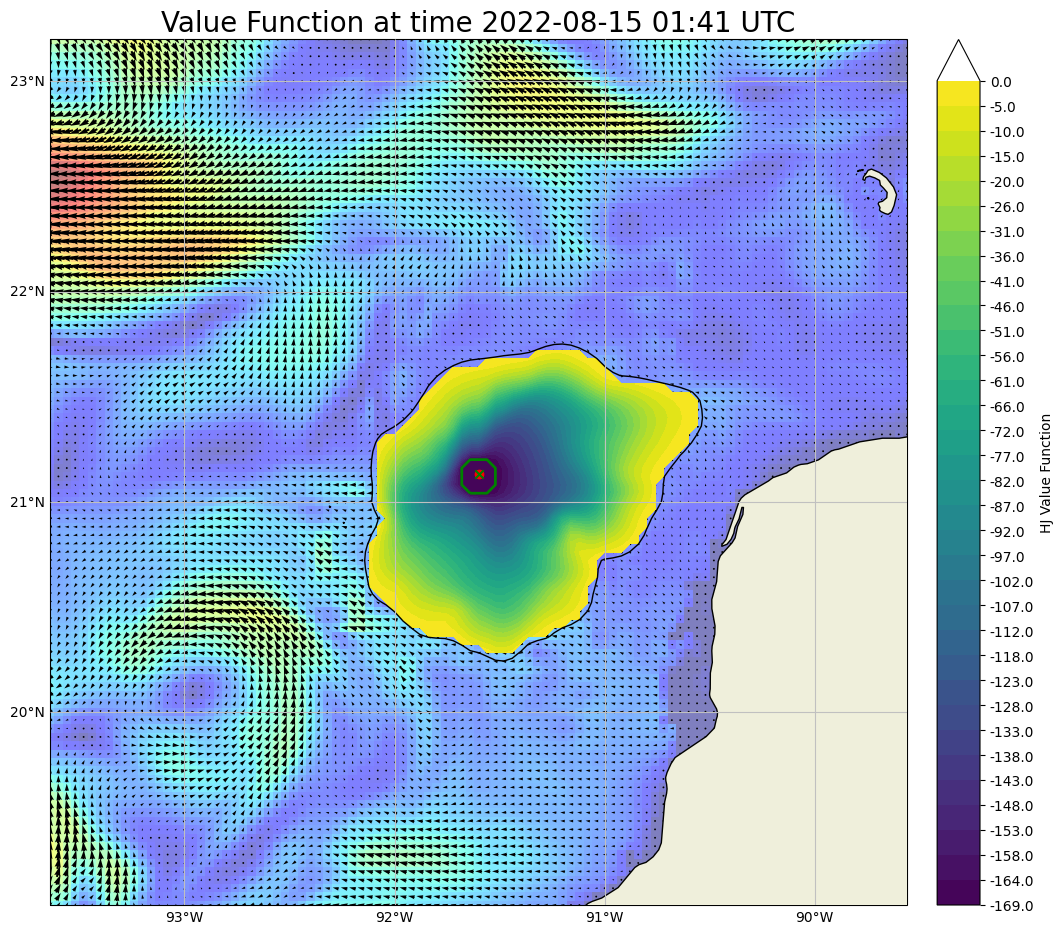

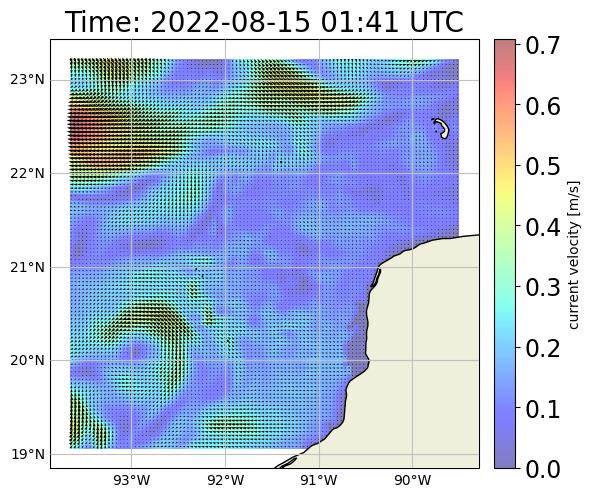

feasible missions found


In [8]:
import random
from ocean_navigation_simulator.reinforcement_learning.missions.MissionGenerator import (
    MissionGenerator,
)
# create the MissionGenerator Config
config = missGenBatchConfig
config_to_add = {
    "scenario_config": arena_config,
    # "problem_timeout": datetime.timedelta(
    #     seconds=exp.get("timeout_in_sec").timeout_in_sec
    # ),
    # "T_goal_in_seconds": exp.get("timeout_in_sec").timeout_in_sec,
}

config = config | config_to_add

results_folder = "/tmp/missions/"
# os.makedirs(results_folder, exist_ok=True)
# seed all of them
all_problems_c3 = []
for worker in range(1):
    mission_generator = MissionGenerator(
        config=config
        | {
            "seed": 2022,#int(random.uniform(0, 1000000)),
            "cache_folder": results_folder + str(worker) + "_",
        },
        c3=c3,
    )
    problems_c3, _, _ = mission_generator.cache_batch()
    all_problems_c3.extend(problems_c3)

In [8]:
problems_c3[0]

Problem [start: [[-91.07407° -91.03462° -91.12069° -91.07997°],                       [21.00497° 20.99111° 20.98426° 21.01121°]],                       ['2022-08-15 01:41:37' '2022-08-15 01:41:37' '2022-08-15 01:41:37'
 '2022-08-15 01:41:37']], end: [-91.599735°,21.12944°], target_radius: 0.10, ttr: 102h] (INone, GNone BNone FI0)

In [9]:
problems_c3[0].extra_info

{'multi_agent': True,
 'timeout_datetime': '2022-08-22T01:41:36+00:00',
 'start_target_distance_deg': [0.5060799750059758,
  0.5452095443896987,
  0.470042784636164,
  0.4992141657232167],
 'feasible': True,
 'ttr_in_h': 102.20753796710662,
 'all_ttr_among_platforms_in_h': [87.73293487629977,
  102.20753796710662,
  82.88782051246473,
  84.90353676794588],
 'random': False,
 'distance_to_shore_deg': [0.5916299588032955,
  0.5522818623795851,
  0.6263024501702324,
  0.5989683761955872],
 'x_cache': [-93.59973501719382, -89.59973501719382],
 'y_cache': [19.129442803186254, 23.129442803186254],
 'factory_seed': 2022,
 'factory_index': 0}

In [11]:
gen_mission_job = c3.GenMissionBatchJobNicolas(**{'options': options.toJson()}).upsert()
#gen_mission_job = c3.GenMissionBatchJob(**{'options': options.toJson()}).upsert()
# gen_mission_job.setMaxConcurrency(12)
# gen_mission_job.setMaxConcurrencyPerNode(15)
gen_mission_job.start()
gen_mission_job

c3.GenMissionBatchJobNicolas(
 typeIdent='BATCHJ:O_NIC_GENMISS_BATCH_JOB',
 id='781d13e1-ad7d-4a5e-9816-b8633cb9f490',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 3, 23, 59, 55, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 3, 23, 59, 55, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 3, 23, 59, 55, tzinfo=datetime.timezone.utc)),
 version=1)

In [23]:
#gen_mission_job = c3.GenMissionBatchJobNicolas.get('88ed422a-dafd-4969-b148-7a9ddd85c0a0')
gen_mission_job.status()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 3, 23, 59, 56, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 completed=datetime.datetime(2023, 2, 4, 0, 8, 40, tzinfo=datetime.timezone.utc),
 status='completed',
 newBatchSubmitted=False)

In [24]:
gen_mission_job.computingActions()
# gen_mission_job.cancel()

c3.JobComputingActionsResult()

In [16]:
len(exp.get('expMissions').expMissions)

TypeError: object of type 'NoneType' has no len()

In [40]:
#Other Utils for the cluster
c3.Cluster.actionDump()

c3.Arry<ClusterAction>([c3.ClusterAction(
  id='977.129441253',
  target='c3/c3/BatchQueue?action=dispatchCompute',
  tenant='c3',
  tag='c3',
  status='Running',
  threadId='181',
  threadGroup='main',
  threadName='Hannibal-55',
  age='02:25:06.863',
  elapsed=8706863,
  secondaryKey='b341f29f-5c0b-44c0-a11e-7f901eeefc24',
  children=c3.Arry<Action>([c3.Action(
              id='977.129441270',
              parentId='977.129441253',
              target='seaweed-control/devseaweedrc1/BatchQueue?action=compute',
              tenant='seaweed-control',
              tag='devseaweedrc1',
              status='Running',
              age='02:25:06.862',
              elapsed=8706862,
              children=c3.Arry<Action>([c3.Action(
                          id='977.129441403',
                          parentId='977.129441270',
                          target='seaweed-control/devseaweedrc1/OceanDataFileDownloadJob?action=dispatchProcessBatch',
                          tenant='seawee

Plot all of them on a map and get distribution information

In [42]:
exp.get('expMissions').expMissions[0].get('missionConfig').missionConfig

{'x_0': [{'lon': -88.42575073242188,
   'lat': 28.74627685546875,
   'date_time': '2022-08-04T21:53:58+00:00'},
  {'lon': -88.4726333618164,
   'lat': 28.76189422607422,
   'date_time': '2022-08-04T21:53:58+00:00'},
  {'lon': -88.46626281738281,
   'lat': 28.767995834350586,
   'date_time': '2022-08-04T21:53:58+00:00'},
  {'lon': -88.40724182128906,
   'lat': 28.731657028198242,
   'date_time': '2022-08-04T21:53:58+00:00'}],
 'x_T': {'lon': -88.46745635584054, 'lat': 28.639831160214904},
 'target_radius': 0.1,
 'seed': 145669,
 'feasible': True,
 'ttr_in_h': 100.12855776011611,
 'multi_agent': True}

In [46]:
from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)
from ocean_navigation_simulator.environment.PlatformState import (
    PlatformState,
    PlatformStateSet,
    SpatialPoint,
)

from ocean_navigation_simulator.utils import units

problems = []
for miss in exp.get('expMissions').expMissions:
    missionConfig = miss.get("missionConfig").missionConfig
    problems.append(CachedNavigationProblem.from_c3_mission_config(missionConfig))

In [47]:
import pandas as pd
from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner)


In [48]:
results_folder = f"{os.getcwd()}/"
df = pd.DataFrame([problem.to_dict() for problem in problems])
df['factory_index'] = 0
df.to_csv(results_folder + "problems.csv")

/tmp/ipykernel_1487/3117225428.py:21: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



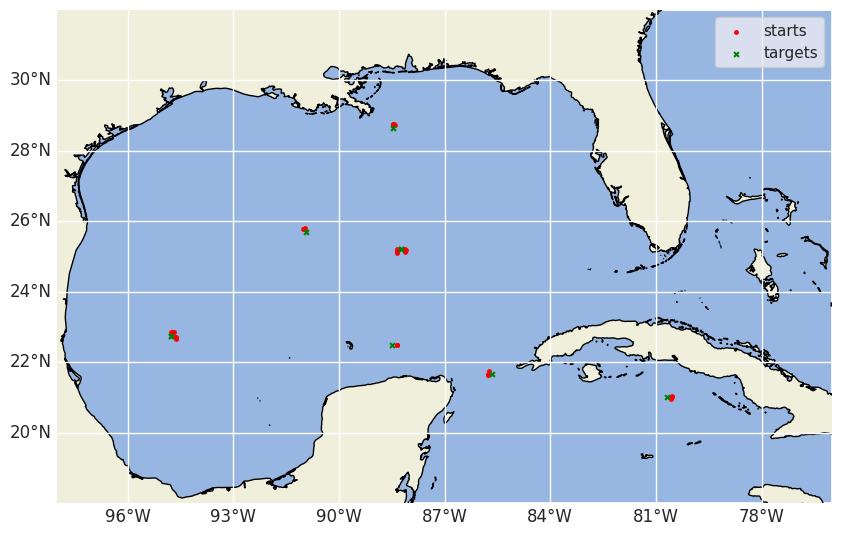

In [49]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_title("Time: " + datetime.fromtimestamp(time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC'))
 
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')
ax.add_feature(cfeature.OCEAN, zorder=0)
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.axis(xmin=-98,xmax=-76)
ax.axis(ymin=18,ymax=32)
for miss_idx in range(len(df)):
    ax.scatter(df.iloc[miss_idx]["x_0_lon"], df.iloc[miss_idx]["x_0_lat"], c="red", marker="o", s=6, label="starts" if miss_idx==0 else None)
ax.scatter(df["x_T_lon"], df["x_T_lat"], c="green", marker="x", s=12, label="targets")
ax.legend()
# ax.get_figure().savefig(f"{analysis_folder}starts_and_targets.png")
ax.get_figure().show()

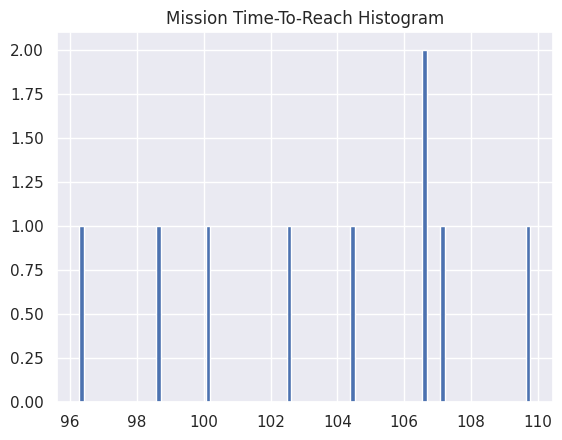

/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl/ocean_navigation_simulator/reinforcement_learning/runners/GenerationRunner.py:392: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



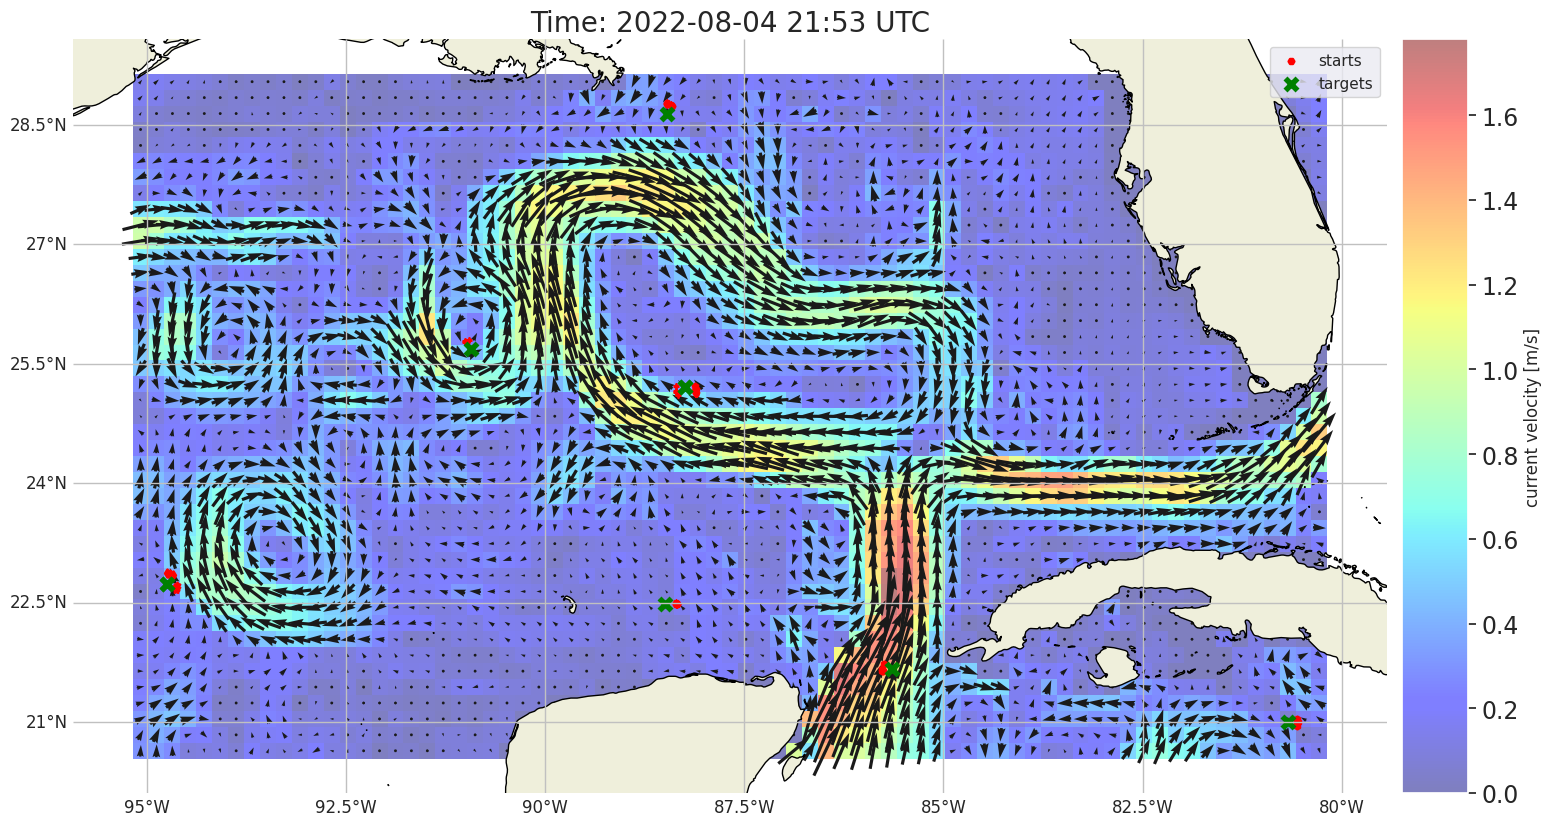

In [50]:
GenerationRunner.plot_ttr_histogram(results_folder)
GenerationRunner.plot_starts_and_targets(
    results_folder=results_folder, pb_filename="problems.csv", scenario_config=arena_config,
)


# Add Observer

In [25]:
# Config for No observer
observer_config = {"observer": None}
# add observer
exp.addObserver(name="NoObserver", observerConfig=observer_config)

c3.ObserverSetting(
 id='multi_agent_dev_2_NoObserver',
 name='NoObserver',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 4, 0, 9, 11, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 4, 0, 9, 11, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 4, 0, 9, 11, tzinfo=datetime.timezone.utc)),
 version=1)

# Add Controller

In [26]:
# Controller Configs
HJMultiTimeConfig = {
    "replan_every_X_seconds": None,
    "replan_on_new_fmrc": True,
    "T_goal_in_seconds": 3600 * 24 * 7,  # 3d, 43200,     # 12h
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner",
    "d_max": 0.0,
    "deg_around_xt_xT_box": 1.0,
    "direction": "multi-time-reach-back",
    "grid_res": 0.02,
    "n_time_vector": 200,
    "progress_bar": True,
    "use_geographic_coordinate_system": True,
}
StraightLineConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.NaiveController.NaiveController"
}
flockingConfig = {
    "unit": "km",
    "interaction_range": 9,  # km
    "grad_clip_range": 0.1,  # km
}
reactiveConfig = {
    "unit": "m",
    "mix_ttr_and_euclidean": False,
    "delta_3": 8800,  # collision threshold (communication - delta_3)
    "delta_2": 2000,  # safe zone threshold  ]communication - delta_2, communication - delta_3[
    "delta_1": 500,  # small threshold so that if distance > communication_thrsld- delta_1 we try to achieve connectivity
    "communication_thrsld": 9000,
    "k_1": 0.25,
    "k_2": 1,
}

MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "hj_naive",  # choose from hj_naive, flocking, reactive_control
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
    "flocking_config": flockingConfig,
    "reactive_control_config": reactiveConfig,
}

In [27]:
exp.experimentName = exp.get('experiment_name')

In [28]:
# add controller
exp.addController(name='hj_naive', ctrlConfig=MultiAgentCtrlConfig)

c3.ControllerSetting(
 id='multi_agent_dev_2_hj_naive',
 name='hj_naive',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 4, 0, 9, 21, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 4, 0, 9, 21, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 4, 0, 9, 21, tzinfo=datetime.timezone.utc)),
 version=1)

# Set missions to ready to run

In [51]:
experiment = 'experiment.id==' + '"' + exp.id + '"'
status = ' && status==' + '"staged_for_feasibility"'
exp_list = c3.Mission.fetch(spec={'include': "[this]",'filter':  experiment}).objs

In [52]:
experiment
exp_list

c3.Arry<Mission>([c3.Mission(
  id='multi_agent_dev_2_batch_seed_100_0',
  meta=c3.Meta(
         tenantTagId=32,
         tenant='seaweed-control',
         tag='devseaweedrc1',
         created=datetime.datetime(2023, 2, 4, 0, 8, 38, tzinfo=datetime.timezone.utc),
         createdBy='worker',
         updated=datetime.datetime(2023, 2, 4, 0, 9, 36, tzinfo=datetime.timezone.utc),
         updatedBy='mariuswiggert@berkeley.edu',
         timestamp=datetime.datetime(2023, 2, 4, 0, 9, 36, tzinfo=datetime.timezone.utc),
         fetchInclude='[]',
         fetchType='Mission'),
  version=2,
  experiment=c3.Experiment(
               id='multi_agent_dev_2',
               T_horizon_FC_Error_Calculation_in_h=96),
  status='ready_to_run',
  missionConfig={'feasible': True,
                  'multi_agent': True,
                  'seed': 145669,
                  'target_radius': 0.1,
                  'ttr_in_h': 100.12855776011611,
                  'x_0': [{'date_time': '2022-08-04T21:53:5

In [53]:
for miss in exp_list:
    miss.status="ready_to_run"
    miss.merge()

# Create Ocean Sim Runs

In [54]:
# Create the Run objects
exp.createOceanSimRuns(ctrl_name='hj_naive_new', obs_name='NoObserver')

True

## Run simulation debug 

In [51]:
exp_filter = 'mission.experiment.id==' + '"' + exp.get('experimentName').experimentName + '"'
runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                              'filter': exp_filter,
                                              'order': "ascending(mission.id)",
                                              'limit': -1
                                             }).objs

In [52]:
run = runs[-2]

In [53]:
run

c3.OceanSimRun(
 id='multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver',
 meta=c3.Meta(
        tenantTagId=32,
        tenant='seaweed-control',
        tag='devseaweedrc1',
        created=datetime.datetime(2023, 2, 2, 23, 37, 9, tzinfo=datetime.timezone.utc),
        createdBy='mariuswiggert@berkeley.edu',
        updated=datetime.datetime(2023, 2, 2, 23, 42, 23, tzinfo=datetime.timezone.utc),
        updatedBy='worker',
        timestamp=datetime.datetime(2023, 2, 2, 23, 42, 23, tzinfo=datetime.timezone.utc),
        fetchInclude='[]',
        fetchType='OceanSimRun'),
 version=3,
 mission=c3.Mission(id='multi_agent_dev_batch_seed_114_1'),
 controllerSetting=c3.ControllerSetting(id='multi_agent_dev_hj_naive'),
 observerSetting=c3.ObserverSetting(id='multi_agent_dev_NoObserver'),
 status='run_failed',
 terminationReason='run_failed',
 oceanSimResult=c3.OceanSimResult(
                  trajectories=c3.AzureFile(
                                 contentLength=207812,
             

In [54]:
 # ensure we have all necessary data to run
this = runs[-2].get(
    "mission.missionConfig, mission.experiment.timeout_in_sec,"
    + "mission.experiment.arenaConfig, mission.experiment.objectiveConfig,"
    + "controllerSetting.ctrlConfig, observerSetting.observerConfig"
)
this

c3.OceanSimRun(
 id='multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver',
 meta=c3.Meta(
        fetchInclude='[{mission:[missionConfig,{experiment:[timeout_in_sec,arenaConfig,objectiveConfig,id]},id]},{controllerSetting:[ctrlConfig,id]},{observerSetting:[observerConfig,id]},id,version]',
        fetchType='OceanSimRun'),
 version=3,
 mission=c3.Mission(
           id='multi_agent_dev_batch_seed_114_1',
           experiment=c3.Experiment(
                        id='multi_agent_dev',
                        arenaConfig={'casadi_cache_dict': {'deg_around_x_t': 2.0,
                                                            'time_around_x_t': 432000},
                                      'multi_agent_constraints': {'collision_thrsld': 0.2,
                                                                  'communication_thrsld': 9,
                                                                  'epsilon_margin': 1,
                                                                  '

In [55]:
# update the entry while it's running
new_osr = c3.OceanSimRun(**{"id": this.id, "status": "running_sim"})
new_osr.merge()


c3.OceanSimRun(
 id='multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver',
 version=4)

In [56]:
import os
import pickle
import logging
import datetime
import numpy as np
import wandb
import matplotlib.pyplot as plt
import pandas as pd

import ocean_navigation_simulator
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.problem_factories.Constructor import Constructor
from ocean_navigation_simulator.environment.PlatformState import SpatioTemporalPoint

In [57]:
# create strings for all files and external directories where to save results
# Set up file paths and download folders
temp_folder = "/tmp/" + this.id + "/"
# create the folder if it doesn't exist yet
if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)
log_file_name = this.id + ".log"
logging.basicConfig(filename=temp_folder + log_file_name, level=logging.DEBUG)
traj_file_name = this.id + ".obj"
extDir = (
    "ocean_sim_run_results/"
    + this.mission.experiment.id
    + "/OceanSimRuns/"
    + this.id
)

# set download directories (ignore set ones in arenaConfig)
arenaConfig = this.mission.experiment.arenaConfig

# Get and set the correct path to the nutrient and monthly average files (for c3) - !! CONFIG gets overwritten!!
filepath = ocean_navigation_simulator.__file__
module_path = os.path.dirname(filepath)
results_path = module_path + "/results/"
# nutrient_path = module_path + "/package_data/nutrients/"
# averages_path = module_path + "/package_data/monthly_averages/"

# arenaConfig["seaweed_dict"]["hindcast"]["source_settings"][
#     "filepath"
# ] = nutrient_path

arenaConfig["timeout"] = this.mission.experiment.timeout_in_sec
to_download_forecast_files = False

# for hindcast
arenaConfig["ocean_dict"]["hindcast"]["source_settings"]["folder"] = (
    "/tmp/" + this.id + "/hindcast_files/"
)
# for forecast
if arenaConfig["ocean_dict"]["forecast"] is not None:
    arenaConfig["ocean_dict"]["forecast"]["source_settings"]["folder"] = (
        "/tmp/" + this.id + "/forecast_files/"
    )
    to_download_forecast_files = (
        arenaConfig["ocean_dict"]["forecast"]["source"] == "forecast_files"
    )

# prepping the file download
point_to_check = SpatioTemporalPoint.from_dict(this.mission.missionConfig["x_0"][0])
t_interval = [
    point_to_check.date_time,
    point_to_check.date_time
    + datetime.timedelta(
        seconds=this.mission.experiment.timeout_in_sec
        + arenaConfig["casadi_cache_dict"]["time_around_x_t"]
        + 7200
    ),
]

arena, controller = None, None

import contextlib

@contextlib.contextmanager
def dummy_context_mgr():
    yield None

100%|##########|  1.0000/1.0 [00:13<00:00, 13.63s/sim_s]
/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning:

No contour levels were found within the data range.



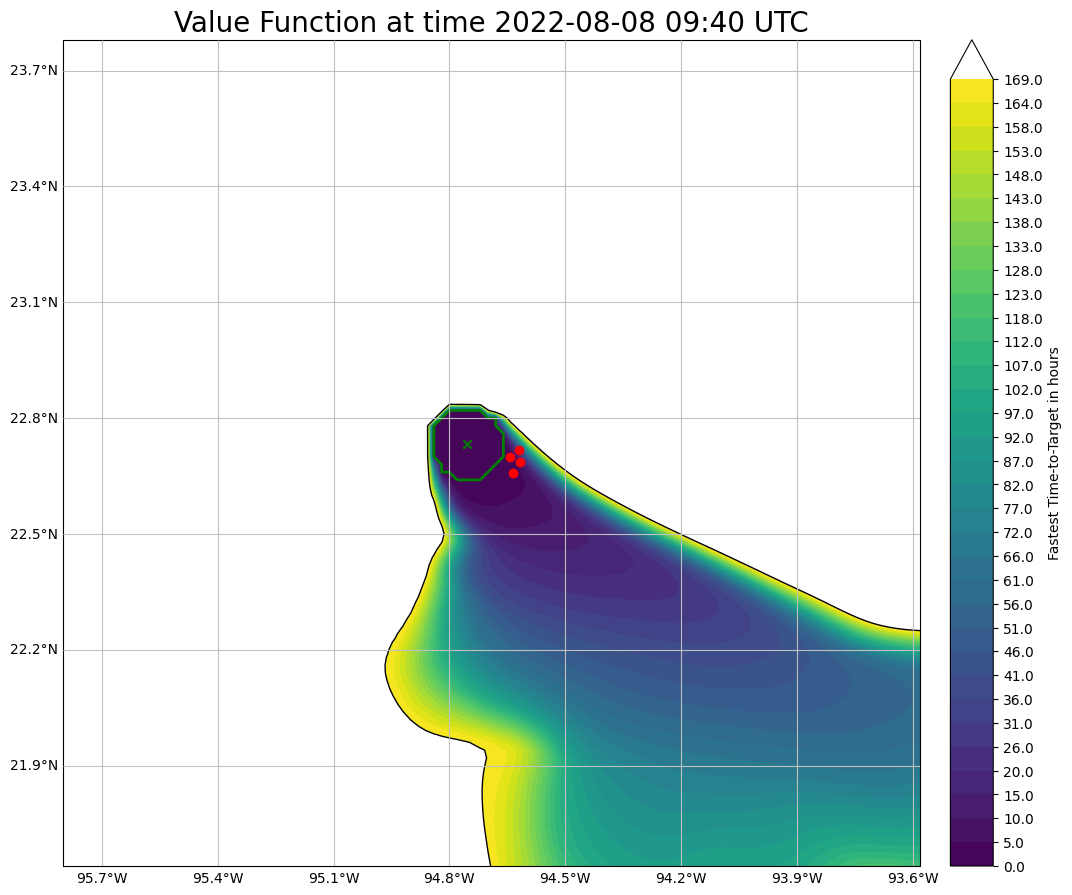

In [58]:

with (
    ArenaFactory.download_files(
        config=arenaConfig,
        type="hindcast",
        t_interval=t_interval,
        c3=c3,
        points=[point_to_check.to_spatial_point()],
    ) as download_hindcast_files_to_local,
    ArenaFactory.download_files(
        config=arenaConfig,
        type="forecast",
        t_interval=t_interval,
        c3=c3,
        points=[point_to_check.to_spatial_point()],
    )
    if to_download_forecast_files
    else dummy_context_mgr() as download_forecast_files_to_local,
):
    # Step 0: Create Constructor object which contains arena, problem, controller and observer
    constructor = Constructor(
        arena_conf=arenaConfig,
        mission_conf=this.mission.missionConfig,
        objective_conf=this.mission.experiment.objectiveConfig,
        ctrl_conf=this.controllerSetting.ctrlConfig,
        observer_conf=this.observerSetting.observerConfig,
    )

    # Step 1.1 Retrieve problem
    problem = constructor.problem

    # Step 1.2: Retrieve arena
    arena = constructor.arena
    observation = arena.reset(platform_set=problem.start_state)
    problem_status = arena.problem_status(problem=problem)

    # Step 2: Retrieve Controller
    controller = constructor.controller

    # log initial reachability snapshot as .jpg and .svg
    controller.get_action(observation=observation) # needed for init of controller
    ax = controller.plot_reachability_snapshot(
        rel_time_in_seconds=0,
        granularity_in_h=5,
        alpha_color=1,
        time_to_reach=True,
        fig_size_inches=(12, 12),
        plot_in_h=True,
        return_ax=True,
    )
    fig = ax.get_figure()
    fig = plt.figure(fig)
    plt.savefig(temp_folder + "reachability_snapshot.svg")
    plt.savefig(temp_folder + "reachability_snapshot.jpg", dpi=80)
    
    # Step 3: Retrieve observer
    observer = constructor.observer
    observer.observe(observation)
    observation.forecast_data_source = observer

    # Step 4: Run Arena
    ctrl_deviation_from_opt = []
    all_pltf_status = [0] * len(this.mission.missionConfig["x_0"])
    min_distances_to_target_over_mission = [np.inf] * len(
        this.mission.missionConfig["x_0"]
    )
    pb_timeout_flag = -1



In [59]:
while not any(status == pb_timeout_flag for status in problem_status):
    # Get action
    action, ctrl_correction = controller.get_action(observation=observation)
    ctrl_deviation_from_opt.append(ctrl_correction)
    # execute action
    observation = arena.step(action)

    # collect data
    min_distances_to_target_over_mission = (
        arena.get_min_or_max_of_two_lists(
            list_a=min_distances_to_target_over_mission,
            list_b=arena.final_distance_to_target(problem=problem),
            min_or_max="min",
        )
    )
    # Observer data assimilation
    observer.observe(observation)
    observation.forecast_data_source = observer

    # update problem status
    problem_status = arena.problem_status(problem=problem)
    # for the final metric, look if platform was able to reach target within T,
    # so keep only max (=1 if pltf reached target)
    all_pltf_status = arena.get_min_or_max_of_two_lists(
        list_a=all_pltf_status, list_b=problem_status, min_or_max="max"
    )

self.last_fmrc_time_planned_with: 0
rel_time: 55228
self.reach_times: [2428, 607228]


KeyboardInterrupt: 

In [62]:
new_osr.status = "finished_running"
new_osr.terminationReason = 'Timeout'#arena.problem_status_text(problem_status)
logged_error_message = None

In [63]:
# Step 4: create the OceanSimResult object with the files and upload it
if arena is not None:
    # Create a large dict with all trajectory data
    trajs_dict = {
        "sim_traj": arena.state_trajectory,
        "sim_ctrl": arena.action_trajectory,
    }
    # if controller is not None:
    #     if len(controller.planned_trajs) > 0:
    #         trajs_dict["plans"] = controller.planned_trajs

    with open(temp_folder + traj_file_name, "wb") as traj_file:
        pickle.dump(trajs_dict, traj_file)

    # Step 4.3 upload the traj_file_name together with the log_file_name to blob storage
    # upload log file
    new_osr.oceanSimResult = c3.OceanSimResult()
    if os.path.exists(temp_folder + log_file_name):
        c3.Client.uploadLocalClientFiles(
            temp_folder + log_file_name,
            extDir + "/logs",
            {"peekForMetadata": True},
        )
        log_file = c3.File(
            **{"url": extDir + "/logs/" + log_file_name}
        ).readMetadata()
        new_osr.oceanSimResult.log_file = log_file
        os.remove(temp_folder + log_file_name)

    if os.path.exists(temp_folder + traj_file_name):
        # upload traj file
        c3.Client.uploadLocalClientFiles(
            temp_folder + traj_file_name,
            extDir + "/trajs",
            {"peekForMetadata": True},
        )
        trajs_file = c3.File(
            **{"url": extDir + "/trajs/" + traj_file_name}
        ).readMetadata()
        new_osr.oceanSimResult.trajectories = trajs_file
        os.remove(temp_folder + traj_file_name)

    # # log shortest distance to target
    # if this.mission.experiment.objectiveConfig["type"] == "nav":
    #     new_osr.minDistanceToTarget = arena.final_distance_to_target(
    #         problem=problem
    #     ) # we already log this in the metric and here we have a list of minDistances instead of a just a float

### Prepare data for WandB
ctrlConfig = this.controllerSetting.ctrlConfig
missionConfig = this.mission.missionConfig
observerConfig = this.observerSetting.observerConfig

# Prepare variables for run naming

# Planning horizon in days
# T_in_days = ctrlConfig["hj_specific_setting"]["T_goal_in_seconds"] / (24 * 3600)

# Prepare string whether we use only HC or FC/HC
if arenaConfig["ocean_dict"]["forecast"] is not None:
    data_sources = "FC_HC"
else:
    data_sources = "HC"

region = arenaConfig["ocean_dict"].get("region", "GOM")

nb_platforms = len(missionConfig["x_0"])
ctrl_name = ctrlConfig["high_level_ctrl"]

umax = arenaConfig["platform_dict"]["u_max_in_mps"]

# Log metrics in WandB
os.environ["WANDB_API_KEY"] = "1f19232e6ccc9981a8a972bee18ba31a94644835"

wandb.init(
    # Set the project where this run will be logged
    project="Master Thesis",
    id=this.id,
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"{this.id}_nb_pltf_{nb_platforms}_{region}_{data_sources}",
    # Track hyperparameters and run metadata
    config={
        "missionConfig": missionConfig,
        "arenaConfig": arenaConfig,
        "ctrlConfig": ctrlConfig,
        "observerConfig": observerConfig,
        "mission.id": this.mission.id,
        "experiment.id": this.mission.experiment.id,
    },
    entity="nhoischen",
)
metrics_dict = arena.save_metrics_to_log(
    all_pltf_status=all_pltf_status,
    min_distances_to_target=min_distances_to_target_over_mission,
    max_correction_from_opt_ctrl=ctrl_deviation_from_opt,
    filename=f"{temp_folder}/metrics_{this.id}.log",
)
metrics_df = pd.DataFrame(data=metrics_dict, index=[0])
wandb.log({"metrics": metrics_df}, commit=False)

# Log state_trajectory as table/dataframe
wandb.log(
    {"data_to_plot": wandb.Table(dataframe=arena.get_plot_data_for_wandb())},
    commit=False,
)

# log trajectory plot on ocean current as .jpg and .svg
ax = arena.plot_all_on_map(problem=problem, show_control_trajectory=False,return_ax=True,)
fig = ax.get_figure()
fig = plt.figure(fig)
plt.savefig(temp_folder + "current_trajectory_on_map.svg")
plt.savefig(temp_folder + "current_trajectory_on_map.jpg", dpi=80)

# log inter-platform distance evolution as .jpg and .svg
ax = arena.plot_distance_evolution_between_platforms(
    xticks_temporal_res=arenaConfig["timeout"] / 12
)
fig = ax.get_figure()
fig = plt.figure(fig)
plt.savefig(temp_folder + "distance_evolution.svg")
plt.savefig(temp_folder + "distance_evolution.jpg", dpi=80)

# log images in wandb
image_traj = wandb.Image(
    temp_folder + "current_trajectory_on_map.jpg",
    caption="Platform trajectories on currents map",
)
image_reach = wandb.Image(
    temp_folder + "reachability_snapshot.jpg",
    caption="Initial reachability plot",
)

image_dist = wandb.Image(
    temp_folder + "distance_evolution.jpg",
    caption="Distance evolution between platform pairs",
)
wandb.log({"Inter-platform distance evolution": image_dist}, commit=False)
wandb.log({"Reachability snapshot": image_reach}, commit=False)
wandb.log({"Platform trajectories": image_traj}, commit=True)

# log trajectory animations
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=7200,
    background="current",
    output=f"{temp_folder}platform_trajectories.mp4",
    fps=10,
)
arena.animate_graph_net_trajectory(
    temporal_resolution=7200,
    plot_ax_ticks=True,
    output=f"{temp_folder}network_graph_trajectory.mp4",
    fps=5,
)

### Save files to c3 and add link to WandB
traj_currents_plot_file_name = "current_trajectory_on_map.svg"
reachability_plot_file_name = "reachability_snapshot.svg"
distance_evol_plot_file_name = "distance_evolution.svg"
traj_currents_animation_file_name = "platform_trajectories.mp4"
traj_network_animation_file_name = "network_graph_trajectory.mp4"

# add platform trajectories plot
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_currents_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_currents_plot_file = c3.File(
    **{"url": extDir + "/logs/" + traj_currents_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_currents_plot_file = traj_currents_plot_file
os.remove(temp_folder + traj_currents_plot_file_name)

# add reachability plot
c3.Client.uploadLocalClientFiles(
    temp_folder + reachability_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
reachability_plot_file = c3.File(
    **{"url": extDir + "/logs/" + reachability_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.reachability_plot_file = reachability_plot_file
os.remove(temp_folder + reachability_plot_file_name)

# add distance evolution plot
c3.Client.uploadLocalClientFiles(
    temp_folder + distance_evol_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
distance_evol_plot_file = c3.File(
    **{"url": extDir + "/logs/" + distance_evol_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.distance_evol_plot_file = distance_evol_plot_file
os.remove(temp_folder + distance_evol_plot_file_name)

# add platform trajectories animation
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_currents_animation_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_currents_animation_file = c3.File(
    **{"url": extDir + "/logs/" + traj_currents_animation_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_currents_animation_file = (
    traj_currents_animation_file
)
os.remove(temp_folder + traj_currents_animation_file_name)

# add graph animation
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_network_animation_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_network_animation_file = c3.File(
    **{"url": extDir + "/logs/" + traj_network_animation_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_network_animation_file = traj_network_animation_file
os.remove(temp_folder + traj_network_animation_file_name)

# LOG URL IN WANDB
wandb.summary[
    "traj_current_plot_svg"
] = traj_currents_plot_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "reachability_plot_svg"
] = reachability_plot_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "distance_evol_plot_svg"
] = distance_evol_plot_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "platf_trajectories_animation"
] = traj_currents_animation_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "traj_network_animation"
] = traj_network_animation_file.generatePresignedUrl("GET", "600d")

wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nhoischen. Use `wandb login --relogin` to force relogin
wandb: ERROR Error while calling W&B API: run nhoischen/Master Thesis/multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run nhoischen/Master Thesis/multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run nhoischen/Master Thesis/multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run nhoischen/Master Thesis/multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver was previously created and deleted; tr

Problem at: /tmp/ipykernel_6049/2293809143.py 75 <cell line: 75>


UsageError: Error communicating with wandb process
For more info see: https://docs.wandb.ai/library/init#init-start-error

wandb: ERROR Error while calling W&B API: run nhoischen/Master Thesis/multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run nhoischen/Master Thesis/multi_agent_dev_batch_seed_114_1_hj_naive_NoObserver was previously created and deleted; try a new run name (<Response [409]>)
Thread SenderThread:
Traceback (most recent call last):
  File "/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/wandb/apis/normalize.py", line 26, in wrapper
    return func(*args, **kwargs)
  File "/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/wandb/sdk/internal/internal_api.py", line 1515, in upsert_run
    response = self.gql(
  File "/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/wandb/sdk/lib/retry.py", line 113, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/home/nicolas/miniconda3/envs/ocean_minimal/l

In [ ]:
ax = controller.plot_reachability_snapshot(
    rel_time_in_seconds=0,
    granularity_in_h=5,
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(12, 12),
    plot_in_h=True,
    return_ax=True,
)

In [ ]:
wandb.finish()

In [ ]:
ax = arena.plot_all_on_map(problem=problem, show_control_trajectory=False,return_ax=True,)

In [ ]:
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=7200,
    background="current",
    output=f"{temp_folder}platform_trajectories.mp4",
    fps=10,
)

# Run Simulation

In [56]:
# Create the Experiment Batch Job Options
options = c3.OceanSimRunBatchJobOptions(**{
    'experiment': exp,
    'actionRuntime': 'nicolas' # enum('marius', 'andreas', 'matthias', 'nicolas')
})

In [57]:
# Start the Batch Job
run_job = c3.OceanSimRunBatchJob(**{'options': options.toJson()}).upsert()
# run_job.numAutoRecoveryAttempts = 1
run_job.start()
run_job

c3.OceanSimRunBatchJob(
 typeIdent='BATCHJ:O_OSRun',
 id='0e1169bb-f4cd-49d9-8a51-a71b63dd8207',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 4, 4, 5, 22, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 4, 4, 5, 22, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 4, 4, 5, 22, tzinfo=datetime.timezone.utc)),
 version=1)

In [60]:
#run_job = c3.OceanSimRunBatchJob.get('03b44bae-1a6e-4fa1-b07e-d906b48b84bf')
run_job.status()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 4, 4, 5, 23, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 completed=datetime.datetime(2023, 2, 4, 4, 5, 27, tzinfo=datetime.timezone.utc),
 status='completed',
 newBatchSubmitted=False)

In [66]:
experiment = 'mission.experiment.id==' + '"' + exp.id + '"'
objs_list = c3.OceanSimRun.fetch(spec={'include': "[this]",'filter':  experiment}).objs
print("Total of {} OceanSimRuns".format(len(objs_list)))

staged_to_run = 0
running_sim = 0
finished_running = 0
run_failed = 0
for run in objs_list:
    if run.status == 'staged_to_run':
        staged_to_run += 1
    elif run.status == 'running_sim':
        running_sim += 1
    elif run.status == 'finished_running':
        finished_running += 1
    elif run.status == 'run_failed':
        run_failed += 1

print("staged_to_run: ", staged_to_run)
print("running_sim: ", running_sim)
print("finished_running: ", finished_running)
print("run_failed: ", run_failed)

Total of 1 OceanSimRuns
staged_to_run:  0
running_sim:  0
finished_running:  0
run_failed:  1


In [41]:
c3.Cluster.actionDump()

500 - DataConnectionNotAvailable - c3.engine.database.DbException_cantGetConnection [8295.170]
message: "Cannot get a database connection for action Target [c3/c3/ProvisionLock?action=fetch] from store postgres configuration [, m_database=c3]: wrapped org.postgresql.util.PSQLException: The connection attempt failed.

    at org.postgresql.core.v3.ConnectionFactoryImpl.openConnectionImpl
    ...
    at c3.db.connector.jdbc.JdbcConnectionPool_Methods.lambda$null$2 (JdbcConnectionPool_Methods.java:114)"
JSON: {"tenant": null, "tag": null, "byThread": null}


C3RuntimeException: 500 - DataConnectionNotAvailable - c3.engine.database.DbException_cantGetConnection [8295.170]
message: "Cannot get a database connection for action Target [c3/c3/ProvisionLock?action=fetch] from store postgres configuration [, m_database=c3]: wrapped org.postgresql.util.PSQLException: The connection attempt failed.

    at org.postgresql.core.v3.ConnectionFactoryImpl.openConnectionImpl
    ...
    at c3.db.connector.jdbc.JdbcConnectionPool_Methods.lambda$null$2 (JdbcConnectionPool_Methods.java:114)"
JSON: {"tenant": null, "tag": null, "byThread": null}

In [67]:
exp_filter = 'mission.experiment.id==' + '"' + exp.get('experimentName').experimentName + '"'
all_exp_runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                            'filter': exp_filter,
                                            'order': "ascending(mission.id)",
                                            'limit': -1
                                            }).objs

In [68]:
all_exp_runs

c3.Arry<OceanSimRun>([c3.OceanSimRun(
  id='multi_agent_dev_2_batch_seed_100_0_hj_naive_NoObserver',
  meta=c3.Meta(
         tenantTagId=32,
         tenant='seaweed-control',
         tag='devseaweedrc1',
         created=datetime.datetime(2023, 2, 4, 0, 9, 42, tzinfo=datetime.timezone.utc),
         createdBy='mariuswiggert@berkeley.edu',
         updated=datetime.datetime(2023, 2, 4, 0, 20, 30, tzinfo=datetime.timezone.utc),
         updatedBy='worker',
         timestamp=datetime.datetime(2023, 2, 4, 0, 20, 30, tzinfo=datetime.timezone.utc),
         fetchInclude='[]',
         fetchType='OceanSimRun'),
  version=3,
  mission=c3.Mission(id='multi_agent_dev_2_batch_seed_100_0'),
  controllerSetting=c3.ControllerSetting(id='multi_agent_dev_2_hj_naive'),
  observerSetting=c3.ObserverSetting(id='multi_agent_dev_2_NoObserver'),
  status='run_failed',
  terminationReason='run_failed',
  oceanSimResult=c3.OceanSimResult(
                   trajectories=c3.AzureFile(
                     

In [69]:
import pandas as pd
def get_results_df(this):
    # get all runs from the database (NOTE this can only get 2000 at a time!)
    exp_filter = 'mission.experiment.id==' + '"' + this.get('experimentName').experimentName + '"'
    all_exp_runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                              'filter': exp_filter,
                                              'order': "ascending(mission.id)",
                                              'limit': -1
                                             }).objs
    # get a list of all termination reasons
    termination_reason = []
    status = []
    arrival_time = []
    minDistanceToTarget = []
    ctrl_obs_name = []
    mission_ids = []

    for run in all_exp_runs:
        # get mission_id
        mission_ids.append(run.get('mission').mission.id)
        # get ctrl_obs setting
        ctrl_obs_name.append(run.get('controllerSetting.name').controllerSetting.name + '__' + run.get('observerSetting.name').observerSetting.name)
        # add outcomes
        termination_reason.append(run.terminationReason)
        status.append(run.status)
        arrival_time.append(run.T_arrival_time)
        minDistanceToTarget.append(run.minDistanceToTarget)

    # Make a df out of it
    df = pd.DataFrame(list(zip(mission_ids, ctrl_obs_name, status, termination_reason, arrival_time,minDistanceToTarget)),
                      columns=['mission_id', 'setting', 'status', 'termination_reason', 'arrival_time', 'minDistance'])
    
    return df

In [70]:
df = get_results_df(exp)

In [71]:
df

,mission_id,setting,status,termination_reason,arrival_time,minDistance
0,multi_agent_dev_2_batch_seed_100_0,hj_naive__NoObserver,run_failed,run_failed,None,None
